In [6]:
import cv2
from env.env import PickPlaceEnv
import matplotlib.pyplot as plt

from moviepy.editor import ImageSequenceClip

pybullet build time: May 19 2023 01:17:28


In [7]:
config = {"pick":  ["pink block",'cyan block', 'brown block'],
          "place": ['pink bowl','gray bowl']}

In [8]:
env = PickPlaceEnv()

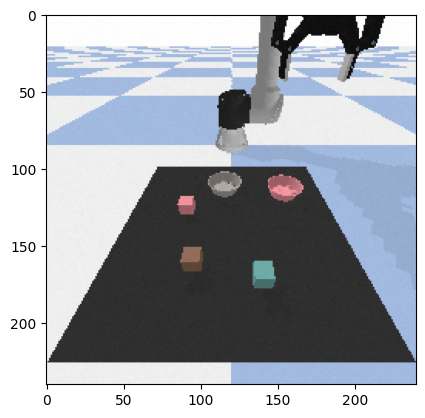

In [9]:
obs = env.reset(config)

img_top = env.get_camera_image()
img_top_rgb = cv2.cvtColor(img_top, cv2.COLOR_BGR2RGB)
plt.imshow(img_top)
plt.show()

In [5]:
_,_,_,_ = env.step({'pick': [0.00850271, -0.40386325, 0.0], 'place': [0.10094152, -0.581147 , 0.0]})

In [6]:
debug_clip = ImageSequenceClip(env.cache_video, fps=25)
display(debug_clip.ipython_display(autoplay=1, loop=1, center=False))
env.cache_video = []

  0%|          | 0/43 [00:00<?, ?it/s]

100%|██████████| 43/43 [00:00<00:00, 668.76it/s]


## CLIPPORT

In [1]:
from clipport.run import run_cliport
import clip
import numpy as np
import os

import jax
import jax.numpy as jnp
import flax
from clipport.model import TransporterNets, n_params
from flax.training import checkpoints
import functools

/home/jeongeun/.local/lib/python3.10/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/jeongeun/.local/lib/python3.10/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
2023-09-25 11:34:20.101562: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def model_state():
    # Initialize model weights using dummy tensors.
    rng = jax.random.PRNGKey(0)
    rng, key = jax.random.split(rng)
    init_img = jnp.ones((4, 224, 224, 5), jnp.float32)
    init_text = jnp.ones((4, 512), jnp.float32)
    init_pix = jnp.zeros((4, 2), np.int32)
    init_params = TransporterNets().init(key, init_img, init_text, init_pix)['params']
    # gpus = jax.devices('gpu')
    # init_params = jax.jit(init_params,device=gpus[1])
    print(f'Model parameters: {n_params(init_params):,}')
    optim = flax.optim.Adam(learning_rate=1e-4).create(init_params)


    ckpt_path = f'ckpt_{40000}'
    if not os.path.exists(ckpt_path):
        !gdown --id 1Nq0q1KbqHOA5O7aRSu4u7-u27EMMXqgP
    optim = checkpoints.restore_checkpoint(ckpt_path, optim)
    print('Loaded:', ckpt_path)
    return optim
optim = model_state()

Model parameters: 4,259,095
Loaded: ckpt_40000


In [3]:
# Coordinate map (i.e. position encoding).
coord_x, coord_y = np.meshgrid(np.linspace(-1, 1, 224), np.linspace(-1, 1, 224), sparse=False, indexing='ij')
coords = np.concatenate((coord_x[..., None], coord_y[..., None]), axis=2)

In [12]:
clip_model, clip_preprocess = clip.load("ViT-B/32",device = 'cuda:1')
clip_model.cuda().eval()

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 47.54 GiB total capacity; 362.13 MiB already allocated; 2.56 MiB free; 368.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [10]:
user_input = 'Pick the blue block and place it on the orange bowl.'  #@param {type:"string"}

# pick_xyz, place_xyz, pick_map, place_map, pick_yx, place_yx = 
obs = run_cliport(env,clip_model,coords, optim, obs, user_input)

RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

## ViLD

In [ ]:
category_names = [
                    'blue block',
                  'red block',
                  'green block',
                  'orange block',
                  'yellow block',
                  'purple block',
                  'pink block',
                  'cyan block',
                  'brown block',
                  'gray block',

                  'blue bowl',
                  'red bowl',
                  'green bowl',
                  'orange bowl',
                  'yellow bowl',
                  'purple bowl',
                  'pink bowl',
                  'cyan bowl',
                  'brown bowl',
                  'gray bowl',
                  
                  ]


# category_names = ['yellow block','red block', 'orange block',
#             'green bowl','brown bowl']

#@markdown ViLD settings.
category_name_string = ";".join(category_names)
max_boxes_to_draw = 8 #@param {type:"integer"}

# Extra prompt engineering: swap A with B for every (A, B) in list.
# prompt_swaps = [('block', 'cube')]

nms_threshold = 0.4 #@param {type:"slider", min:0, max:0.9, step:0.05}
min_rpn_score_thresh = 0.4  #@param {type:"slider", min:0, max:1, step:0.01}
min_box_area = 10 #@param {type:"slider", min:0, max:10000, step:1.0}
max_box_area = 3000  #@param {type:"slider", min:0, max:10000, step:1.0}
vild_params = max_boxes_to_draw, nms_threshold, min_rpn_score_thresh, min_box_area, max_box_area


In [ ]:
from vild.forward import vild
from env.env import PICK_TARGETS, PLACE_TARGETS

In [ ]:
np.random.seed(2)
if config is None:
  pick_items = list(PICK_TARGETS.keys())
  pick_items = np.random.choice(pick_items, size=np.random.randint(1, 5), replace=False)

  place_items = list(PLACE_TARGETS.keys())[:-9]
  place_items = np.random.choice(place_items, size=np.random.randint(1, 6 - len(pick_items)), replace=False)
  config = {"pick":  pick_items,
            "place": place_items}
  print(pick_items, place_items)

obs = env.reset(config)

img_top = env.get_camera_image_top()
img_top_rgb = cv2.cvtColor(img_top, cv2.COLOR_BGR2RGB)
plt.imshow(img_top)
image_path = "./2db.png"

In [ ]:
vild_model = vild(clip_model,category_name_string, vild_params)

In [ ]:
found_objects, boxes = vild_model.infer(image_path,plot_on=True,prompt_swaps=[])
